Multi-media Information Processing (EECE 7217)
Assignment 3
University of Memphis, Spring 2023

Bereket Kebede, Gradaute Student, EECE, U00827234
For this assignment, we are using a dataset from the UCI machine learning repository.


MLP on Wheat Seeds

Instructor: Prof. Michael Bartz

In [12]:
import numpy as np


class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [ ]:
####################################################
# import necessary libraries 

import pandas as pd
import os
import json
import time
import pickle
import requests
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [19]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')  

In [ ]:
####################################################
# retreive data

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
def fetch_data(fname='seeds_dataset.txt'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

In [ ]:
####################################################
# define the features

FEATURES  = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry",
    "groove"
]

df = pd.read_csv(DATA, sep='\s+',names=FEATURES + ['target'])
display(df)

,area,perimeter,compactness,length,width,asymmetry,groove,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [ ]:
X = df.loc[:, FEATURES]
y = df.loc[:, 'target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

print('Labels counts in y:', np.bincount(y)[1:])
print('Labels counts in y_train:', np.bincount(y_train)[1:])
print('Labels counts in y_test:', np.bincount(y_test)[1:])

Labels counts in y: [70 70 70]
Labels counts in y_train: [46 52 49]
Labels counts in y_test: [24 18 21]


In [20]:
from sklearn.neural_network import MLPClassifier

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


predicted: [2 3 3 3 1 2 1 3 3 3 2 1 2 1 1 3 3 1 2 1 1 2 2 3 1 3 1 3 2 2 2 2 1 1 3 1 3
 2 1 3 2 3 2 3 2 2 3 3 2 3 2 3 2 2 3 1 3 3 3 3 1 3 2]
true class: [1 3 1 3 1 2 1 3 3 3 2 1 1 1 1 3 3 1 1 1 1 1 2 3 1 3 1 3 1 2 2 2 2 1 1 2 3
 2 1 3 1 3 2 3 2 2 3 3 2 3 2 3 2 2 1 1 3 3 1 3 2 1 2]

-----------------metrics-------------------------

precision    0.782836
recall       0.777778
accuracy     0.777778
f1           0.765272
dtype: float64


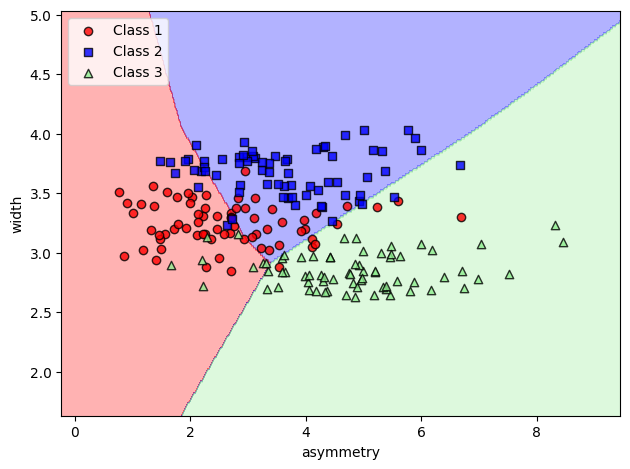

In [26]:
selecte_feature_1 = FEATURES[5]
selecte_feature_2 = FEATURES[4]

#lr = LogisticRegression()

lr = MLPClassifier(random_state=1, max_iter=300)
lr.fit(X_train.loc[:, [selecte_feature_1, selecte_feature_2]],
       y_train)

expected  = np.array(y_test)
predicted = lr.predict(X_test.loc[:, [selecte_feature_1, selecte_feature_2]])

print('predicted:', predicted)
print('true class:', expected)

print('\n-----------------metrics-------------------------\n')
scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))
print(pd.DataFrame(scores).mean())

plot_decision_regions(X.loc[:, [selecte_feature_1, selecte_feature_2]].to_numpy(),
                      y, classifier=lr)

#plt.title('not hello')
plt.xlabel(selecte_feature_1)
plt.ylabel(selecte_feature_2)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


predicted: [2 3 3 3 1 2 1 3 3 3 2 1 1 1 1 3 3 1 1 1 1 2 2 3 1 3 1 3 1 2 2 2 2 1 3 2 3
 2 1 3 1 3 2 3 2 2 3 3 2 3 2 3 2 2 3 1 3 3 3 3 2 3 2]
true class: [1 3 1 3 1 2 1 3 3 3 2 1 1 1 1 3 3 1 1 1 1 1 2 3 1 3 1 3 1 2 2 2 2 1 1 2 3
 2 1 3 1 3 2 3 2 2 3 3 2 3 2 3 2 2 1 1 3 3 1 3 2 1 2]

-----------------metrics-------------------------

precision    0.907326
recall       0.888889
accuracy     0.888889
f1           0.884461
dtype: float64


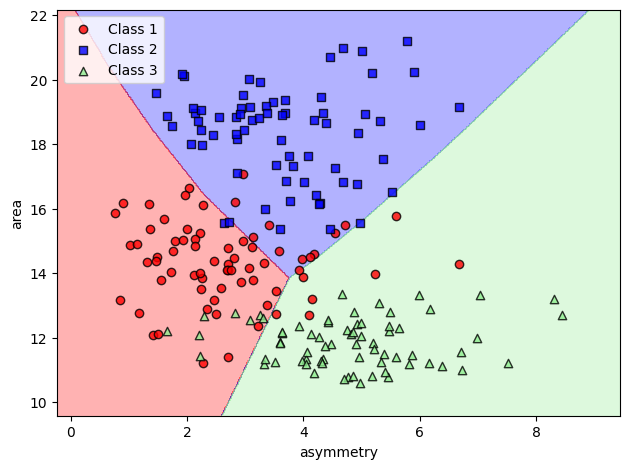

In [25]:
selecte_feature_1 = FEATURES[5]
selecte_feature_2 = FEATURES[0]

#lr = LogisticRegression()
lr = MLPClassifier(random_state=1, max_iter=300)

lr.fit(X_train.loc[:, [selecte_feature_1, selecte_feature_2]],
       y_train)


expected  = np.array(y_test)
predicted = lr.predict(X_test.loc[:, [selecte_feature_1, selecte_feature_2]])

print('predicted:', predicted)
print('true class:', expected)

print('\n-----------------metrics-------------------------\n')
scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))
print(pd.DataFrame(scores).mean())

plot_decision_regions(X.loc[:, [selecte_feature_1, selecte_feature_2]].to_numpy(),
                      y, classifier=lr)

#plt.title('hello')
plt.xlabel(selecte_feature_1)
plt.ylabel(selecte_feature_2)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()